# Combining wxee and eemont

[eemont](https://github.com/davemlz/eemont) is a Python package that adds powerful functionality like cloud masking and spectral index calculation to Earth Engine classes. Because `TimeSeries` in `wxee` are a subclass of `ee.ImageCollection`, any methods from `eemont` that work with an `ImageCollection` will also work with a `TimeSeries`! 

In this tutorial, we'll see how we can combine the two packages by generating monthly aggregates of cloud-masked NDVI data from MODIS.

## Setup

In [ ]:
# !pip install wxee
# !pip install eemont

In [1]:
import ee
import wxee
import eemont

ee.Authenticate()
ee.Initialize()

## Creating a Time Series

First, we'll load one year of daily imagery from the MODIS sensor as a `TimeSeries`. 

In [2]:
modis = wxee.TimeSeries("MODIS/006/MOD09GA").filterDate("2020", "2021")

### Pre-Processing with eemont

Now, we'll use `eemont` to mask clouds and calculate the Normalized Difference Vegetation Index (NDVI) of each image in the time series. For more details, see the eemont documentation on [cloud masking](https://eemont.readthedocs.io/en/latest/guide/maskingClouds.html) and [spectral indices](https://eemont.readthedocs.io/en/latest/guide/spectralIndices.html).

In [3]:
ts = (modis
      .maskClouds(maskShadows=False)
      .scaleAndOffset()
      .spectralIndices(index="NDVI")
      .select("NDVI")
)

### Monthly Aggregation

Now we'll aggregate our daily cloud-masked NDVI images to monthtly medians.

In [4]:
monthly_ts = ts.aggregate_time("month", ee.Reducer.median())

Before we download our data, we'll clip the MODIS images to a country layer in order to remove areas of ocean.

In [5]:
countries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")
monthly_ts_land = monthly_ts.map(lambda img: img.clip(countries))

## Downloading the Time Series

Finally, we're ready to specify a region of interest around the African continent.

In [6]:
region = ee.Geometry.Polygon(
    [[[-20.94783493615687, 38.550044216461366],
      [-20.94783493615687, -36.736958952789465],
      [53.58341506384313, -36.736958952789465],
      [53.58341506384313, 38.550044216461366]]]
)

And download our `TimeSeries` to an `xarray.Dataset`!

In [7]:
ds = monthly_ts_land.wx.to_xarray(region=region, scale=20_000)

Requesting data:   0%|          | 0/12 [00:00<?, ?it/s]

## Visualizing the Time Series

### The Easy Way

An `xarray.Dataset` can be easily plotted by arranging it into columns along the time dimension.

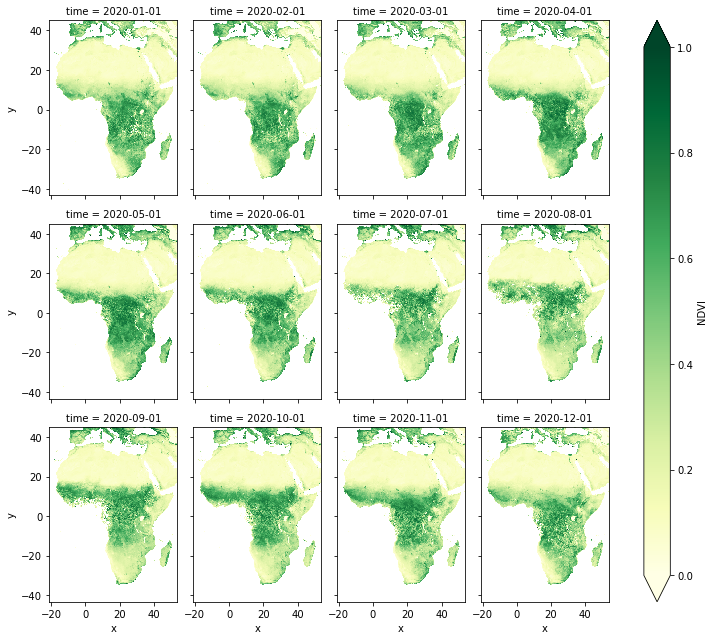

In [8]:
ds.NDVI.plot(col="time", col_wrap=4, cmap="YlGn", vmin=0, vmax=1, aspect=0.8)

### The Fun Way

If we want a more exciting visualization, we can use the [hvplot](https://github.com/holoviz/hvplot) library and its `xarray` module to create time series animations!

In [ ]:
# !pip install hvplot

In [9]:
import hvplot.xarray

In [10]:
ds.NDVI.hvplot(
    groupby="time", clim=(0, 1), cmap="YlGn", 
    frame_height=600, aspect=0.8, 
    widget_location="bottom", widget_type="scrubber",
)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=11, width=550)
        [2] HSpacer()